In [1]:
import torch
from torch.utils.data import DataLoader
from torchvision.transforms import transforms
from torchvision.datasets import ImageFolder

import numpy as np
import matplotlib.pyplot as plt

In [2]:
data_dir = '../data/'
test_dir = data_dir + 'images/test/'

transform = transforms.Compose([
    transforms.Resize((256, 256)),
    transforms.CenterCrop(224),
    transforms.ToTensor(),
    transforms.Normalize(mean=[0.485, 0.456, 0.406], std=[0.229, 0.224, 0.225]),
])

test_set = ImageFolder(test_dir, transform=transform, target_transform=None)
test_loader = DataLoader(test_set, batch_size=1, shuffle=False)

for images, _ in test_loader:
    input_batch = images
    break

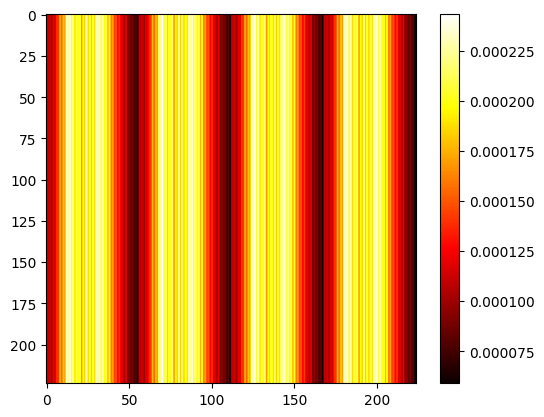

In [3]:
model = torch.load('../models/ResNet50_pretrained-epoch9-batch_size32-lr0.001-loss0.1753.pt')
model.eval();
device = next(model.parameters()).device.type

gradients = None
def hook_function(module, grad_input, grad_output):
    global gradients
    gradients = grad_output[0]
handle = model.layer1[0].register_full_backward_hook(hook_function)
input_batch = input_batch.to(device)
input_batch.requires_grad_()
output = model(input_batch)
loss = output.norm()
model.zero_grad()
loss.backward()
handle.remove()

gradients = gradients.cpu().data.numpy()
gradients = np.abs(gradients).mean(axis=(1, 2))  # Mean across channels
gradients = np.squeeze(gradients)
gradients_resized = np.resize(gradients, (input_batch.shape[2], input_batch.shape[3]))

plt.imshow(gradients_resized, cmap='hot')
plt.colorbar()
plt.show()